In [2]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6 MB 7.0 MB/s 
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 222 kB 9.3 MB/s 
     |████████████████████████████████| 376 kB 44.6 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 


# Graph Classification with Graph Neural Networks

[Previous: Node Classification with Graph Neural Networks](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX)

In this tutorial session we will have a closer look at how to apply **Graph Neural Networks (GNNs) to the task of graph classification**.
Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties.
Here, we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable given a task at hand.

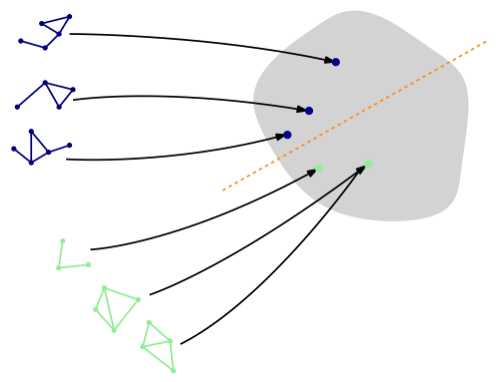

The most common task for graph classification is **molecular property prediction**, in which molecules are represented as graphs, and the task may be to infer whether a molecule inhibits HIV virus replication or not.

The TU Dortmund University has collected a wide range of different graph classification datasets, known as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/), which are also accessible via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) in PyTorch Geometric.
Let's load and inspect one of the smaller ones, the **MUTAG dataset**:

In [3]:
import torch
from torch_geometric.datasets import TUDataset


dataset = TUDataset(root='data/', name='PROTEINS')


print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

print('=============================================================')

# Gather some statistics about the first graph.
print(f'Dim of edge_attr: {data.edge_attr}')
#print(f'Number of edge_index: {data.edge_index}')


Extracting data/PROTEINS/PROTEINS.zip
Processing...
Done!
Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2

Data(edge_index=[2, 162], x=[42, 3], y=[1])
Number of nodes: 42
Number of edges: 162
Average node degree: 3.86
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
Dim of edge_attr: None


# Make TUDataset OGB compatible

<class 'torch_geometric.datasets.tu_dataset.TUDataset'>


In [3]:
#1. Constructor
!pip install ogb
from ogb.io import DatasetSaver
import numpy as np
import networkx as nx
import os

# constructor
dataset_name = 'ogbg-TUDataset2'
saver = DatasetSaver(dataset_name = dataset_name, is_hetero = False, version = 1)

     |████████████████████████████████| 67 kB 4.3 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=a4e87a342aa904c3b953b6bc44632d007875159ef9c1842eb894f0060aefa88a
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


In [4]:
# 2. Saving graph list
# generate random graphs with node and edge features
graph_list = []
num_data = 100
for i, g in enumerate(dataset):
    #g = nx.fast_gnp_random_graph(10, 0.5)
    #print(g)
    graph = dict()
    graph['edge_index'] = np.array(g.edge_index) #.transpose() 
    num_edges = graph['edge_index'].shape[1]

    graph['num_nodes'] = len(g.x)
    # optionally, add node/edge features
    graph['node_feat'] = np.array(g.x).astype(np.int64)
    #graph['edge_feat'] = np.array(g.edge_attr).astype(np.int64)[:,0:3]
    #print(graph['edge_feat'])
    graph_list.append(graph)
# saving a list of graphs
saver.save_graph_list(graph_list)



  0%|          | 0/1113 [00:00<?, ?it/s]

dict_keys(['edge_index', 'num_nodes', 'node_feat'])
Saving edge_index
Saving all the files!
Validating...
Reading saved files
Loading necessary files...
This might take a while.
Processing graphs...
Checking read graphs and given graphs are the same


100%|██████████| 1113/1113 [00:00<00:00, 11554.64it/s]


In [5]:
# 3. Saving target labels
num_classes = 2
labels = []
for i, g in enumerate(dataset):
  labels.append(g.y)
  #labels[i] = g.y

labels = np.array([labels]).transpose()
saver.save_target_labels(labels)

In [6]:
# 4. Saving dataset split
split_idx = dict()
num_data = len(dataset)
perm = np.random.permutation(num_data)
split_idx['train'] = perm[:int(0.8*num_data)]
split_idx['valid'] = perm[int(0.8*num_data): int(0.9*num_data)]
split_idx['test'] = perm[int(0.9*num_data):]
saver.save_split(split_idx, split_name = 'random')

In [7]:
# 5. Copying mapping directory
mapping_path = 'mapping/'

# prepare mapping information first and store it under this directory (empty below).
os.makedirs(mapping_path)
os.mknod(os.path.join(mapping_path, 'README.md'))

saver.copy_mapping_dir(mapping_path)

In [8]:
# 6. Saving task information
saver.save_task_info(task_type = 'classification', eval_metric = 'acc', num_classes = num_classes)

classification
2


In [9]:
# 7. Getting meta information dictionary
meta_dict = saver.get_meta_dict()

In [10]:
# 8. Testing the dataset object
from ogb.graphproppred import GraphPropPredDataset
dataset = GraphPropPredDataset(dataset_name, meta_dict = meta_dict)

# see if it is working properly
print(dataset[0])
print(dataset.get_idx_split())

100%|██████████| 1113/1113 [00:00<00:00, 214287.83it/s]

Loading necessary files...
This might take a while.
Processing graphs...
Saving...
({'edge_index': array([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,
         8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12,
        12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16, 16,
        16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19,
        20, 20, 20, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24,
        24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29,
        29, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33,
        33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 37, 37,
        37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 41,
        41, 41],
       [11, 22, 32, 23, 31, 41, 24, 29, 34,  4, 28, 29, 38, 39,  3, 14,
        28, 29, 38, 39,  6,  7, 26,  5,  7,  8,  5,  6, 19, 25,  6,  9,
        10, 25, 35, 

In [11]:
print(dataset[0][0])

{'edge_index': array([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,
         8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12,
        12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16, 16,
        16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19,
        20, 20, 20, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24,
        24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29,
        29, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33,
        33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 37, 37,
        37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 41,
        41, 41],
       [11, 22, 32, 23, 31, 41, 24, 29, 34,  4, 28, 29, 38, 39,  3, 14,
        28, 29, 38, 39,  6,  7, 26,  5,  7,  8,  5,  6, 19, 25,  6,  9,
        10, 25, 35,  8, 10, 19, 21, 25, 35,  8,  9, 20,  0, 22, 32, 31,
        33, 41, 14, 15, 34, 39, 

In [26]:
# 9. Zipping and cleaning up
saver.zip()
saver.cleanup()

In [ ]:
torch.load('submission_ogbg_TUDataset/meta_dict.pt')

{'add_inverse_edge': 'False',
 'additional edge files': 'None',
 'additional node files': 'None',
 'binary': 'True',
 'dir_path': 'submission_ogbg_TUDataset/TUDataset',
 'download_name': 'TUDataset',
 'eval metric': 'acc',
 'has_edge_attr': 'True',
 'has_node_attr': 'True',
 'is hetero': 'False',
 'num classes': 2,
 'num tasks': 1,
 'split': 'random',
 'task type': 'classification',
 'url': 'https://snap.stanford.edu/ogb/data/graphproppred/TUDataset.zip',
 'version': 1}

# Cora Graph-of-Words